#  성별에 따른 데이터 시각화 및 나이브 베이즈이론을 활용한 예약 이행 여부 예측
## 캐글  문제 : https://www.kaggle.com/joniarroba/noshowappointments
### 데이터

https://raw.githubusercontent.com/ZubairHussain/Appointment-No-Show-/master/No-show-Issue-Comma-300k.csv

In [2]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns 

In [3]:
!curl https://raw.githubusercontent.com/ZubairHussain/Appointment-No-Show-/master/No-show-Issue-Comma-300k.csv\
    -o ./data/no_show.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0
  0     0    0     0    0     0      0      0 --:--:--  0:00:02 --:--:--     0
  0     0    0     0    0     0      0      0 --:--:--  0:00:03 --:--:--     0
  0 23.6M    0  6855    0     0   1706      0  4:02:00  0:00:04  4:01:56  1706
  0 23.6M    0 81703    0     0  16265      0  0:25:23  0:00:05  0:25:18 16330
  0 23.6M    0  231k    0     0  39354      0  0:10:29  0:00:06  0:10:23 52738
  2 23.6M    2  567k    0     0  82800      0  0:04:59  0:00:07  0:04:52  126k
  3 23.6M    3  934k    0     0   116k      0  0:03:27  0:00:08  0:03:19  209k
  5 23.6M    5 1302k    0     0   144k      0  0:02

In [4]:
data =  pd.read_csv('./data/no_show.csv')
data.head()

,Age,Gender,AppointmentRegistration,ApointmentData,DayOfTheWeek,Status,Diabetes,Alcoolism,HiperTension,Handcap,Smokes,Scholarship,Tuberculosis,Sms_Reminder,AwaitingTime
0,19,M,2014-12-16T14:46:25Z,2015-01-14T00:00:00Z,Wednesday,Show-Up,0,0,0,0,0,0,0,0,-29
1,24,F,2015-08-18T07:01:26Z,2015-08-19T00:00:00Z,Wednesday,Show-Up,0,0,0,0,0,0,0,0,-1
2,4,F,2014-02-17T12:53:46Z,2014-02-18T00:00:00Z,Tuesday,Show-Up,0,0,0,0,0,0,0,0,-1
3,5,M,2014-07-23T17:02:11Z,2014-08-07T00:00:00Z,Thursday,Show-Up,0,0,0,0,0,0,0,1,-15
4,38,M,2015-10-21T15:20:09Z,2015-10-27T00:00:00Z,Tuesday,Show-Up,0,0,0,0,0,0,0,1,-6


# 1. 데이터 점검

### 1.1 데이터 정리 및 오타 제거

일부 column의 오타를 알맞게 고치고 예약 등록날과 예약된 날의 간격의 수를 양수로 바꾸어준다.  

In [5]:
data.columns

Index(['Age', 'Gender', 'AppointmentRegistration', 'ApointmentData',
       'DayOfTheWeek', 'Status', 'Diabetes', 'Alcoolism', 'HiperTension',
       'Handcap', 'Smokes', 'Scholarship', 'Tuberculosis', 'Sms_Reminder',
       'AwaitingTime'],
      dtype='object')

In [6]:
data.rename(columns = {'ApointmentData':'AppointmentData', 'Alcoolism': 'Alcoholism', #철자가 틀린것을 고치기
                         'HiperTension': 'Hypertension', 'Handcap': 'Handicap'}, inplace = True) 

data.head(5)     

,Age,Gender,AppointmentRegistration,AppointmentData,DayOfTheWeek,Status,Diabetes,Alcoholism,Hypertension,Handicap,Smokes,Scholarship,Tuberculosis,Sms_Reminder,AwaitingTime
0,19,M,2014-12-16T14:46:25Z,2015-01-14T00:00:00Z,Wednesday,Show-Up,0,0,0,0,0,0,0,0,-29
1,24,F,2015-08-18T07:01:26Z,2015-08-19T00:00:00Z,Wednesday,Show-Up,0,0,0,0,0,0,0,0,-1
2,4,F,2014-02-17T12:53:46Z,2014-02-18T00:00:00Z,Tuesday,Show-Up,0,0,0,0,0,0,0,0,-1
3,5,M,2014-07-23T17:02:11Z,2014-08-07T00:00:00Z,Thursday,Show-Up,0,0,0,0,0,0,0,1,-15
4,38,M,2015-10-21T15:20:09Z,2015-10-27T00:00:00Z,Tuesday,Show-Up,0,0,0,0,0,0,0,1,-6


In [7]:
data.AwaitingTime = data.AwaitingTime.apply(abs) #등록날과 예약된 날의 간격이 음수로 되어있는데 이것을 절대값을 씌어주어 양수로 고쳐준다
print(data.AwaitingTime.head())

0    29
1     1
2     1
3    15
4     6
Name: AwaitingTime, dtype: int64


###  1.2  에러 체크 및 제거
데이터를 확인하여 NAN이나 맞지 않는 값을 찾아내 제거한다.

In [8]:
print('Age:',sorted(data.Age.unique())) # 각 데이터들의 잘못된 값이나 NAN값을 확인한다 SORTED는 값을 정렬해주고 
print('Gender:',data.Gender.unique()) # unique는 중복없이 값을 보여준다
print('DayOfTheWeek:',data.DayOfTheWeek.unique())
print('Status:',data.Status.unique())
print('Diabetes:',data.Diabetes.unique())
print('Alcoholism:',data.Alcoholism.unique())
print('Hypertension:',data.Hypertension.unique())
print('Handicap:',data.Handicap.unique())
print('Smokes:',data.Smokes.unique())
print('Scholarship:',data.Scholarship.unique())
print('Tuberculosis:',data.Tuberculosis.unique())
print('Sms_Reminder:',data.Sms_Reminder.unique())
print('AwaitingTime:',sorted(data.AwaitingTime.unique()))

Age: [-2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 108, 113]
Gender: ['M' 'F']
DayOfTheWeek: ['Wednesday' 'Tuesday' 'Thursday' 'Friday' 'Monday' 'Saturday' 'Sunday']
Status: ['Show-Up' 'No-Show']
Diabetes: [0 1]
Alcoholism: [0 1]
Hypertension: [0 1]
Handicap: [0 1 2 3 4]
Smokes: [0 1]
Scholarship: [0 1]
Tuberculosis: [0 1]
Sms_Reminder: [0 1 2]
AwaitingTime: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 6

-1과 -2같이 잘못된 나이와 데이터 정리를 위해 100세 이상의 나이를 모두 제거 한다

In [9]:
data = data[(data.Age >= 0) & (data.Age <= 100)]

###  1.3  전체 객체에서 남자 여자 비율  및 예약 이행 비율 확인

In [10]:
df = pd.crosstab(index = data['Gender'], columns = data.Status).reset_index() 
##crosstab은 그룹화할 행을 인덱스에 그룹화할 열을 columns에 넣고 각 행에 따른 Column의 개수를 보여준다
df['Sum']= pd.DataFrame([((data['Gender']== 'F').sum()), ((data['Gender']== 'M').sum())])                      
df

Status,Gender,No-Show,Show-Up,Sum
0,F,59879,140593,200472
1,M,30840,68655,99495


In [11]:
all_oj = (data['Gender']== 'M').sum() + (data['Gender']== 'F').sum()  # 전체 객체수
print("Man : ", round((data['Gender']== 'M').sum() /all_oj , 5)*100 , '%')  #round는 퍼센트를 구할때 유용한 라이브러리로 , 5는 5개의 자리를 
print("Woman : ",round((data['Gender']== 'F').sum() /all_oj , 5)*100 , '%') # 나타낸다는 것을 의미한다

Man :  33.169 %
Woman :  66.83099999999999 %


In [12]:
FM = data[(data['Gender']== 'F')]  #여자만 있는 데이터프레임 생성
f_oj = (data['Gender']== 'F').sum()  # 여자 객체수
print("WoMan No-Show : ", round((FM['Status']== 'No-Show').sum() /f_oj , 5)*100 , '%')  # 여자가 예약 이행 안한 비율
print("WoMan Show-up : ", 100-round((FM['Status']== 'No-Show').sum() /f_oj , 5)*100 , '%')  # 여자가 예약 이행 한 비율

WoMan No-Show :  29.869 %
WoMan Show-up :  70.131 %


In [13]:
MM = data[(data['Gender']== 'M')] #남자만 있는 데이터프레임 생성
m_oj = (data['Gender']== 'M').sum()  # 남자 객체수
print("Man No-Show : ", round((MM['Status']== 'No-Show').sum() /m_oj , 5)*100 , '%')  # 남자가 예약 이행 안한 비율
print("Man Show-up : ", 100-round((MM['Status']== 'No-Show').sum() /m_oj , 5)*100 , '%') # 남자가 예약 이행 한 비율

Man No-Show :  30.997000000000003 %
Man Show-up :  69.003 %


# 2. 데이터 탐구

### 2.1 여러가지 데이터를 이용하여 남자와 여자 예약 이행 여부 시각화 

#### 나이에 따른 예약 이행 여부 시각화

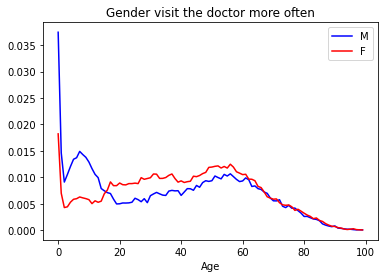

In [14]:
df = data[data.Status == 'Show-Up'] ## 예약 이행한 것만 추출후 df에 저장
range_df = pd.DataFrame()    
range_df['Age'] = range(100)
men = range_df.Age.apply(lambda x: len(df[(df.Age == x) & (df.Gender == 'M')]))  #이름없는함수이며 일회용으로 사용된다 
women = range_df.Age.apply(lambda x: len(df[(df.Age == x) & (df.Gender == 'F')]))
plt.xlabel('Age') # X축의 이름 
plt.title('Gender visit the doctor more often') #그래프의 이름 설정
plt.plot(range(100),men/(data['Gender']== 'M').sum(), 'b') #남자의 연령별 예약 이행 비율
plt.plot(range(100),women/(data['Gender']== 'F').sum(), color = 'r') #여자의 연령별 예약 이행 비율
plt.legend(['M','F'])
plt.show()

#### 각종 질병 발생 시에 남녀 예약 이행 비율

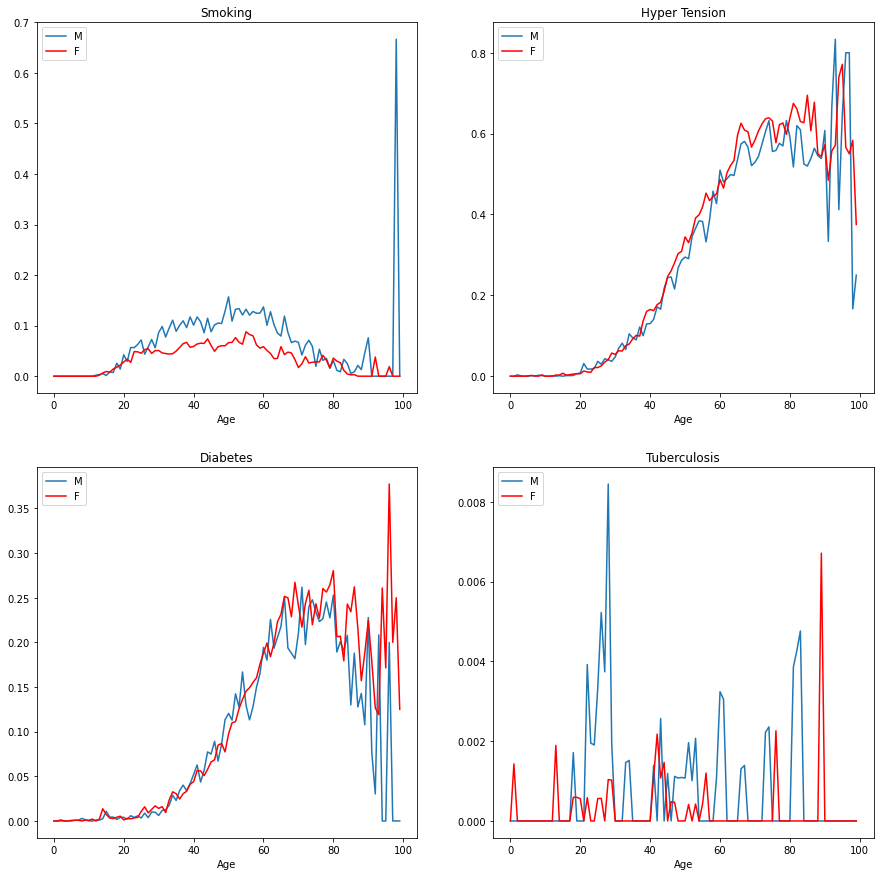

In [15]:
men_smoke = range_df.Age.apply(lambda x: len(df[(df.Age == x) & (df.Gender == 'M') & (df.Smokes == 1)])) #남자이며 흡연자
women_smoke = range_df.Age.apply(lambda x: len(df[(df.Age == x) & (df.Gender == 'F') & (df.Smokes == 1)])) #여자이며 흡연자

men_tension = range_df.Age.apply(lambda x: len(df[(df.Age == x) & (df.Gender == 'M') & (df.Hypertension == 1)])) #남자이며 고혈압
women_tension = range_df.Age.apply(lambda x: len(df[(df.Age == x) & (df.Gender == 'F') & (df.Hypertension == 1)])) #여자이며 고혈압
 
men_Diabetes = range_df.Age.apply(lambda x: len(df[(df.Age == x) & (df.Gender == 'M') & (df.Diabetes == 1)])) #남자이며 당뇨병
women_Diabetes = range_df.Age.apply(lambda x: len(df[(df.Age == x) & (df.Gender == 'F') & (df.Diabetes == 1)])) #여자이며 당뇨병

men_Tuber = range_df.Age.apply(lambda x: len(df[(df.Age == x) & (df.Gender == 'M') & (df.Tuberculosis == 1)])) #남자이며 결핵
women_Tuber = range_df.Age.apply(lambda x: len(df[(df.Age == x) & (df.Gender == 'F') & (df.Tuberculosis == 1)]))#여자이며 결핵

plt.figure(figsize = (15,15)) ## 그래프 사이즈
plt.subplot(221) ## 행 열 그리고 그 행열에 위치 
plt.plot(range(100),men_smoke/men)  # 세로축을 비율로 만들기위해 전체 남자에서 남자흡연자를 나눈다.
plt.plot(range(100),women_smoke/women, color = 'r')
plt.title('Smoking') #제목
plt.legend(['M','F'], loc = 2)
plt.xlabel('Age')           

plt.subplot(222)
plt.plot(range(100),men_tension/men)
plt.plot(range(100),women_tension/women, color = 'r')
plt.title('Hyper Tension')
plt.legend(['M','F'], loc = 2)
plt.xlabel('Age')

plt.subplot(223)
plt.plot(range(100),men_Diabetes/men)
plt.plot(range(100),women_Diabetes/women, color = 'r')
plt.title('Diabetes')
plt.legend(['M','F'], loc = 2)
plt.xlabel('Age')

plt.subplot(224)
plt.plot(range(100),men_Tuber/men)
plt.plot(range(100),women_Tuber/women, color = 'r')
plt.legend(['M','F'], loc = 2)
plt.xlabel('Age')

plt.title('Tuberculosis')
plt.show()

대부분의 질병은 남녀 비율이 비슷하지만  결핵에 한해서는 남자의 비율이 높다

#### 예약 등록날과 예약 당일날과의 간격

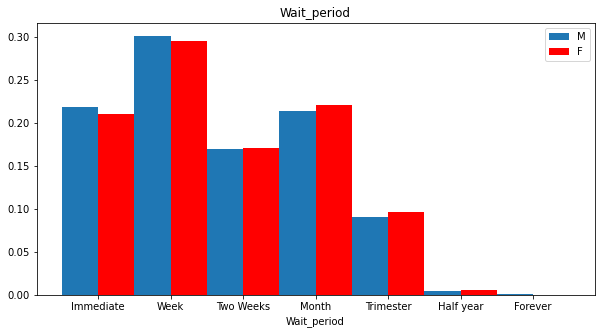

In [16]:
bins = [0, 2, 7, 14, 30, 90, 180, 9999] # 예약 시간과의 공백이 막연히 숫자로 만 되어있어서 문자로 만들어주기위한 기준배열
labels = ["Immediate",  "Week" ,"Two Weeks", "Month", "Trimester" , "Half year" , "Forever"]
wait_period = pd.cut(data.AwaitingTime, bins, labels=labels) #cut는 한 column에서  리스트를 사용하여 기준을 나눈다.
data['Wait_period'] = wait_period # 새로운 column을 만들어 이것을 넣고 예약 이행자들만 추출한다
df = data[data.Status == 'Show-Up']
wait_df =  pd.DataFrame(labels) 
men_wait = wait_df[wait_df.columns[0]].apply(lambda x: len(df[(df.Wait_period == x) & (df.Gender == 'M')])) 
women_wait = wait_df[wait_df.columns[0]].apply(lambda x: len(df[(df.Wait_period == x) & (df.Gender == 'F')]))

plt.figure(figsize = (10,5)) # 그래프 사이즈
plt.bar(range(7), men_wait/len(df[df.Gender == 'M']), width = 0.5)  #막대를 7개만들고 막대 크기를 0.5로한다 
plt.bar(range(7)+0.5*np.ones(len(range(7))), women_wait/len(df[df.Gender == 'F']), width = 0.5, color = 'r')
plt.xticks(range(7) + 0.25*np.ones(len(range(7))), labels)  # x축의 라벨 삽입

plt.title('Wait_period')
plt.xlabel('Wait_period')
plt.legend(['M','F'])
plt.show()

#### 어떤 요일을 가장 많이 선호하는가에 대한 시각화

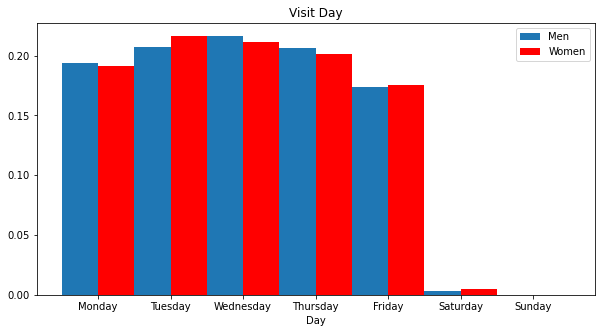

In [17]:
Days = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']  # 요일을 리스트로 만든다
Days_df = pd.DataFrame(Days)  #그것을 데이터 프레임으로 만든다

men_days = Days_df[Days_df.columns[0]].apply(lambda x: len(df[(df.DayOfTheWeek == x) & (df.Gender == 'M')]))
women_days = Days_df[Days_df.columns[0]].apply(lambda x: len(df[(df.DayOfTheWeek == x) & (df.Gender == 'F')]))
plt.figure(figsize = (10,5))
plt.bar(range(7), men_days/len(df[df.Gender == 'M']), width = 0.5)
plt.bar(range(7)+0.5*np.ones(len(range(7))), women_days/len(df[df.Gender == 'F']), width = 0.5, color = 'r')
plt.xticks(range(7) + 0.25*np.ones(len(range(7))),Days)

plt.title('Visit Day')
plt.xlabel('Day')
plt.legend(['Men','Women'])
plt.show()

예약 공백기간에서 남자들은 최근 예약을 잘 이행하는 반면에 여자들은 오래 된 예약을 더 잘 지키는 경향이 있다
요일 같은 경우에는 주말에 멀수록 예약자들이 많았고 남녀 비율은 요일마다 들쭉날쭉하므로 큰 영향이 없어보였다.

#### 월 별 예약 이행자에 대한 시각화

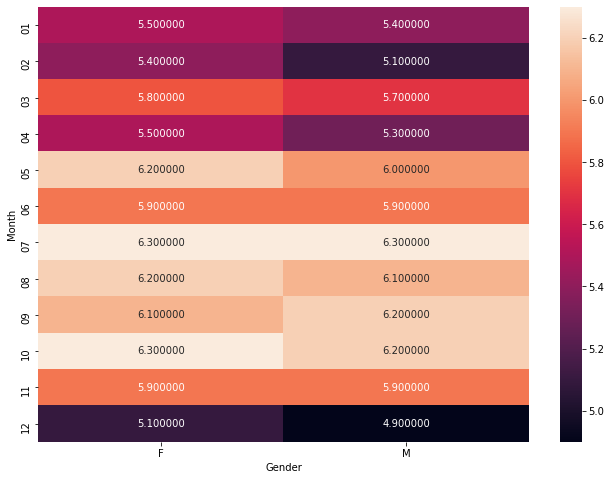

In [18]:
dts = data.copy() #데이터복사를 한 이유는 원본 데이터가 들어있는 변수에 영향을 주지 않기위함이다
dts['Month'] = dts['AppointmentData'].apply(lambda x: x[5:7]) # 5:7은  날짜에서 월만 추출한다는것이다 
dts = dts[dts.Status == 'Show-Up']
dts= dts[["Month","Gender"]]

dts = pd.crosstab(index = dts['Month'], columns = dts.Gender) #월을 인덱스에 컬럼에 성별을 넣는 새로운 데이터프레임 생성

dts['F'] = round((dts['F']/f_oj),3) *100
dts['M'] = round((dts['M']/m_oj),3) *100
plt.figure(figsize=(11,8))
sns.heatmap(dts, annot=True, fmt='f') ##annot는 각 셀에 값을 표시할지 여부 fmt는 표현 방식 f는 실수형  
plt.show()

병원 이용객은 여름 가을에 가장 많았으며 특히 휴가철인 7월에 절정을 찍었다. 하지만 남녀의 차이에는 큰 영향이 없었다.

#### 하루 중에 어떤 시간에 가장 많이 예약을 등록하러 오는지에 대한 시각화

C:\Users\choe\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


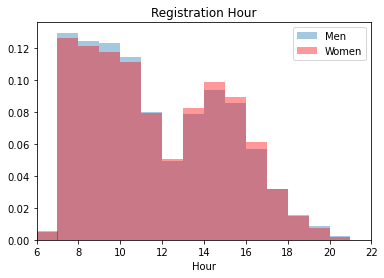

In [19]:

data['Time'] = data['AppointmentRegistration'].apply(lambda x: int(x[11:13])) ##커널밀도 추정 히스토그램을 스무디하게 평활화
sns.distplot(data.Time[data.Gender == 'M'], bins = range(24),norm_hist = True, kde = False)
sns.distplot(data.Time[data.Gender == 'F'], bins = range(24),norm_hist = True, kde = False, color = 'r')
                                                    ##norm_hist y의 값을 퍼센트값
plt.xlim([6,22]) # x축 범위 설정 병원이 6시부터 22시까지 운영하기 때문이다
plt.title('Registration Hour')
plt.xlabel('Hour')
plt.legend(['Men','Women'])
plt.show()

남자들은 주로 아침에 많이 예약을 등록하고 여자는 낮에 많이 예약을 등록한다 

### 2.2 두 가지 질병을 가진 사람의 예약 이행 여부 비교

지금까지는 한 가지의 조건만으로 비교했는데 이번엔 알코올 의존증과 폐암을 동시에 비교한다

In [20]:
data2 = data.copy() 
data2.eval("Show = Status == 'Show-Up'", inplace=True) # inplace는 새 dataframe을 반환할지 기존 것을 변경할지말이다
                                                        # 기본적으로 false로 설정된다
data2.eval("No = Status == 'No-Show'", inplace=True)   # eval은 파이썬 표현식만 포함 가능하다
groups = data2[['Gender', 'Smokes', 'Alcoholism', "Show", "No"]].groupby(['Gender', 'Smokes', 'Alcoholism'])  
                                                                #  컬럼을 가져오고 groupby는 그중에서 색인으로 할것을 뽑는다
gps = pd.DataFrame(groups.mean()) # 데이터 프레임 생성
gps["No-count"] = groups.sum()["No"] # 예약 불 이행자의 객체수를 더한다
gps["Sh-count"] = groups.sum()["Show"] # 예약 이행자의 객체수를 더한다
gps

Show        No  No-count  Sh-count
Gender Smokes Alcoholism                                        
F      0      0           0.704274  0.295726     56211    133867
              1           0.649186  0.350814       388       718
       1      0           0.664078  0.335922      2509      4960
              1           0.576141  0.423859       771      1048
M      0      0           0.693024  0.306976     27964     63131
              1           0.663296  0.336704       666      1312
       1      0           0.681319  0.318681      1218      2604
              1           0.618462  0.381538       992      1608

신기하게도 두 가지 병을 앓고 있는 사람들의 예약 이행 비율이 건강한사람들보다 더 작았고 이것은 남녀 모두에게 나타났다.

#### 밀접한 관계의 합병증

당뇨병을 앓고 있는 사람들은 고혈압을, 고혈압을 가지고 있는 사람들은 당뇨병을 가지고 있는 경우가 많은데 그 만큼 두 가지의 병의 관계는 깊다. 그래서 이번엔 밀접한 관계에 있는 두 가지의 병을 묶어서 수치를 계산해 보았다.

In [21]:
groups = data2[['Gender','Hypertension','Diabetes', "Show", "No"]].groupby(['Gender','Hypertension','Diabetes'])
gps = pd.DataFrame(groups.mean())
gps["No-count"] = groups.sum()["No"]
gps["Sh-count"] = groups.sum()["Show"]
gps

Show        No  No-count  Sh-count
Gender Hypertension Diabetes                                        
F      0            0         0.686039  0.313961     47631    104079
                    1         0.735242  0.264758       740      2055
       1            0         0.749374  0.250626      8113     24258
                    1         0.750294  0.249706      3395     10201
M      0            0         0.675870  0.324130     25675     53537
                    1         0.707723  0.292277       439      1063
       1            0         0.745917  0.254083      3376      9911
                    1         0.754277  0.245723      1350      4144

밀접한 관계에 있는 당뇨와 고혈압의 경우에는 위와는 정반대로 약속 이행 비율이 더 높게 나타났다 이것 또한 남녀 모두에게 나타났다

# 3. 데이터 예측

코드 출처 https://www.kaggle.com/somrikbanerjee/d/joniarroba/noshowappointments/predicting-show-up-no-show

먼저 반의 데이터로 기계학습을 한 뒤에 이것을 기반으로 나머지 반의 데이터의 예약 이행 여부 확률을 구한다

남자의 경우는 홀수개의 데이터이기 때문에 하나를 제외한다

In [22]:
FM_train = FM[['Age', 'Diabetes','Hypertension', 'Tuberculosis', 'Smokes',   # 나이, 질병, 고혈압, 당뇨병, 흡연등의 컬럼을 가져와  
                         'Alcoholism', 'Scholarship']].iloc[:100236]  #학습을 시킨다
F_train = FM.Status[:100236]

FM_test = FM[['Age', 'Diabetes','Hypertension', 'Tuberculosis', 'Smokes',
                         'Alcoholism', 'Scholarship']].iloc[100236:]
F_test = FM.Status[100236:]


MM_train = MM[['Age', 'Diabetes','Hypertension', 'Tuberculosis', 'Smokes',
                         'Alcoholism', 'Scholarship']].iloc[:49747]
M_train = MM.Status[:49747]
MM_test = FM[['Age', 'Diabetes','Hypertension', 'Tuberculosis', 'Smokes',
                         'Alcoholism', 'Scholarship']].iloc[49747:]

M_test = FM.Status[49747:]

naive_bayes --- http://laonple.blog.me/220867768192

### naive_bayes

나이브 베이즈는 분류기를 만들 수 있는 간단한 기술로써 단일 알고리즘을 통한 훈련이 아닌 일반적인 원칙에 근거한 여러 알고리즘들을 이용하여 훈
련된다. 모든 나이브 베이즈 분류기는 공통적으로 모든 특성 값은 서로 독립임을 가정한다. 

나이브 베이즈의 장점. 
* 첫째, 일부의 확률 모델에서 나이브 베이즈 분류는 지도 학습 (Supervised Learning) 환경에서 매우 효율적으로 훈련 될 수 있다. 
* 둘째, 분류에 필요한 파라미터를 추정하기 위한 트레이닝 데이터의 양이 매우 적다는 것이다. 
* 셋째, 간단한 디자인과 단순한 가정에도 불구하고, 나이브 베이즈 분류는 많은 복잡한 실제 상황에서 잘 작동한다. 

MultinomialNB는 다중 분산 데이터에 대한 나이브 베이지안 알고리즘을 구현하고 텍스트 분류에 사용되는 2 개의 고전적인 나이브 베이지안의 변형 중 하나이다.
<img src="나이브베이즈.png", width=300, heigth=300>
클래스와 특성의 값이 훈련 데이터에서 발생 하지 않는 경우에는, 빈도수 기반의 확률 추정치는 0이 된다. 이것은 이 추정치가 곱해질 때 다른 확률의 모든 정보를 없앨 수 있기 때문에 문제가 될 수 있다. 따라서, 대부분의 확률 추정에서는 그 값이 0이 되지 않도록 가짜 수(pseudocount)라는 작은 샘플 보정값을 통합하여 사용하는 경우가 대부분이다. 나이브 베이즈의 이러한 정규화 방법은 가짜 수(pseudocount) 1일 경우 라플라스 정규화(Laplace smoothing)라고 불리고, 일반적으로 리드스톤 정규화(Lidstone smoothing)라고 불린다.


In [23]:
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import MultinomialNB  
               

clf =  MultinomialNB().fit(FM_train, F_train)
print('women Accuracy:', round(accuracy_score(F_test,  
                                        clf.predict(FM_test)), 5) * 100, '%')

clf2 =  MultinomialNB().fit(MM_train, M_train)
print('man Accuracy:', round(accuracy_score(M_test, 
                                        clf2.predict(MM_test)), 5) * 100, '%')

women Accuracy: 70.029 %
man Accuracy: 70.143 %
